## VWAP Reversion EDA — Research Overview

- Research question: What is the empirical probability that intraday price reverts to VWAP after a sufficiently large deviation, and how does that probability vary by higher-timeframe regime (Hurst), deviation size, time-of-day, and volatility?
- Data: Polygon 5-minute aggregates for crypto assets; key columns: open, high, low, close, volume, vwap. API key read from `polygon_key.txt`.
- Event definition:
  - Trigger: |close − anchored VWAP| / anchored VWAP ≥ threshold (e.g., 0.5%, 1.0%, 1.5%). Anchored VWAP resets per UTC day.
  - Outcome (success): signed deviation flips across zero within N bars (e.g., 5, 10, 20), capturing a return to VWAP.
- Context (regimes): Rolling Hurst (R/S) on 1H returns, smoothed with EMA; label MR ≤ 0.45, NOISY 0.45–0.55, TREND ≥ 0.55.
- EDA outputs:
  - Base P(revert) by regime and asset; conditional structure by deviation bin × regime × side; time-of-day and volatility slices; stability over time (first vs second half).
  - Visuals: heatmaps, reliability curves, Hurst plot with bands, time-of-day curves, TTR histograms.
- Decision gate (EDA-only): STOP if rare/flat/unstable; KEEP if base edge exists, conditional structure is monotonic, and stability is acceptable. Gate evaluated per-asset and overall.
- Packaging: Each run is saved to `studies/<timestamp>_VWAP_Reversion/` with config, summary tables, and plots so the workspace remains clean.

How to reuse for a new study:
- Edit `ASSETS`, `START/END`, `DEV_THRESH`, `HORIZONS`, and `STUDY_NAME` in the config cell.
- Run top-to-bottom. Caching (data_cache/) avoids refetching; per-asset gating prevents weak assets from blocking the study.


In [1]:
# Notebook starter
# This cell creates a local .venv for THIS notebook and installs requirements.
import os, sys, subprocess
from pathlib import Path

ROOT = Path.cwd().resolve()
VENV_DIR = ROOT / '.venv'
REQ = ROOT / 'requirements.txt'
if not REQ.exists():
    # Fallback to workspace requirements
    REQ = ROOT.parent / 'requirements.txt'

# Create venv if missing
if not VENV_DIR.exists():
    subprocess.run([sys.executable, '-m', 'venv', str(VENV_DIR)], check=True)

# Pip path inside venv
PIP = VENV_DIR / ('Scripts' if sys.platform.startswith('win') else 'bin') / ('pip.exe' if sys.platform.startswith('win') else 'pip')
PY = VENV_DIR / ('Scripts' if sys.platform.startswith('win') else 'bin') / ('python.exe' if sys.platform.startswith('win') else 'python')

# Install minimal requirements
if REQ.exists():
    subprocess.run([str(PIP), 'install', '--upgrade', 'pip'], check=True)
    subprocess.run([str(PIP), 'install', '-r', str(REQ)], check=True)

print('Local venv ready:', VENV_DIR)


Local venv ready: /Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/.venv


In [2]:
# Kernel switch to local venv
import os, sys
from pathlib import Path
ROOT = Path.cwd().resolve()
VENV_DIR = ROOT / '.venv'
PY = VENV_DIR / ('Scripts' if sys.platform.startswith('win') else 'bin') / ('python.exe' if sys.platform.startswith('win') else 'python')
if Path(sys.executable).resolve() != PY.resolve():
    os.execv(str(PY), [str(PY), '-m', 'ipykernel_launcher', '-f', sys.argv[-1]])
else:
    print('Using local venv kernel')


Using local venv kernel


### 2) Imports & Config
This cell defines study parameters and verifies core imports are available.
- Assets (crypto only)
- Date range
- Intraday bar (5m), Hurst params, deviation thresholds, horizons
- Study name used when packaging


In [3]:
# 2) Imports & Config
import importlib, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Parameters
ASSETS = ['C:EURUSD','C:GBPUSD','C:USDJPY','C:USDCHF','C:AUDUSD','C:USDCAD']
START, END = '2023-01-01', '2025-09-01'
INTRADAY_MULTIPLIER = 5
H_WIN, H_EMA, H_BANDS = 200, 8, (0.45, 0.55)
DEV_THRESH = [0.05, 0.10, 0.20]  # FX deviations smaller (percent)
HORIZONS = [5, 10, 20]
STUDY_NAME = 'VWAP_Reversion_FX'

# Confirm imports
for m in ['polygon','pandas','numpy','matplotlib','sklearn','scipy','plotly']:
    try:
        importlib.import_module(m)
        print(f'OK import: {m}')
    except Exception as e:
        print(f'Import warning: {m}: {e}')


OK import: polygon
OK import: pandas
OK import: numpy
OK import: matplotlib
OK import: sklearn
OK import: scipy
OK import: plotly


In [4]:
# 3) Helpers Import (with safe reload)
# Loads reusable utilities for auth, data, features, Hurst/regimes, events, EDA checks, and packaging.
import sys, importlib
if 'helpers' in sys.modules:
    importlib.reload(sys.modules['helpers'])
else:
    import helpers  # noqa: F401
    importlib.reload(helpers)

from helpers import (
    read_polygon_key, get_polygon_client, fetch_aggregates,
    compute_vwap, rolling_sigma, atr, time_of_day_bucket,
    rolling_hurst, label_h_regime,
    deviation_pct_from_vwap, label_vwap_reversion,
    conditional_probability_table, reliability_curve,
    plot_heatmap, split_time_halves, terciles,
    monotonicity_check, stability_summary, decision_gate,
    package_study,
)
print('Helpers imported (reloaded).')


Helpers imported (reloaded).


### 4) Data Loading
Fetch 5m aggregates from Polygon for each asset and build a coverage table.
Notes:
- Crypto tickers are normalized (e.g., BTC-USD → X:BTCUSD) in helpers.
- DataFrame index is tz-aware (UTC).


In [5]:
# 4) Data Loading
assets_data = {}
for sym in ASSETS:
    df = fetch_aggregates(sym, START, END, multiplier=INTRADAY_MULTIPLIER, timespan='minute')
    assets_data[sym] = df
    print(sym, len(df), df.index.min(), '->', df.index.max())

# Coverage table
rows = []
for sym, df in assets_data.items():
    rows.append({
        'asset': sym,
        'start': str(df.index.min()) if len(df) else None,
        'end': str(df.index.max()) if len(df) else None,
        'rows': len(df),
        'missing_pct': round(100*df.isna().mean().mean() if len(df) else 100.0, 2),
    })
coverage = pd.DataFrame(rows)
coverage


C:EURUSD 198594 2023-01-01 18:20:00+00:00 -> 2025-09-01 23:55:00+00:00
C:GBPUSD 196248 2023-01-01 18:20:00+00:00 -> 2025-09-01 23:55:00+00:00
C:USDJPY 196953 2023-01-01 18:20:00+00:00 -> 2025-09-01 23:55:00+00:00
C:USDCHF 202016 2023-01-01 00:10:00+00:00 -> 2025-09-01 23:55:00+00:00
C:AUDUSD 197878 2023-01-01 18:00:00+00:00 -> 2025-09-01 23:55:00+00:00
C:USDCAD 197217 2023-01-01 18:00:00+00:00 -> 2025-09-01 23:55:00+00:00


,asset,start,end,rows,missing_pct
0,C:EURUSD,2023-01-01 18:20:00+00:00,2025-09-01 23:55:00+00:00,198594,0.0
1,C:GBPUSD,2023-01-01 18:20:00+00:00,2025-09-01 23:55:00+00:00,196248,0.0
2,C:USDJPY,2023-01-01 18:20:00+00:00,2025-09-01 23:55:00+00:00,196953,0.0
3,C:USDCHF,2023-01-01 00:10:00+00:00,2025-09-01 23:55:00+00:00,202016,0.0
4,C:AUDUSD,2023-01-01 18:00:00+00:00,2025-09-01 23:55:00+00:00,197878,0.0
5,C:USDCAD,2023-01-01 18:00:00+00:00,2025-09-01 23:55:00+00:00,197217,0.0


### 4b) Save Downloaded Data for Reuse
Persist raw 5m aggregates locally so re-runs can skip refetching.
- Saved next to this notebook under `data_cache/`
- One file per asset and the current date range
- Tries Parquet (pyarrow) and falls back to compressed CSV if unavailable


In [6]:
# Save to data_cache/
cache_dir = ROOT / 'data_cache'
cache_dir.mkdir(exist_ok=True)

for sym, df in assets_data.items():
    base = f"{sym.replace(':','_').replace('/','-')}_{START}_{END}_5m"
    pq_path = cache_dir / f"{base}.parquet"
    csv_path = cache_dir / f"{base}.csv.gz"
    try:
        # Try Parquet
        df.to_parquet(pq_path)
        print('Saved', sym, '->', pq_path)
    except Exception as e:
        print('Parquet unavailable, falling back to CSV for', sym, '|', e)
        try:
            df.to_csv(csv_path, index=True, compression='gzip')
            print('Saved', sym, '->', csv_path)
        except Exception as e2:
            print('Failed to save', sym, e2)


Parquet unavailable, falling back to CSV for C:EURUSD | Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
Saved C:EURUSD -> /Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/data_cache/C_EURUSD_2023-01-01_2025-09-01_5m.csv.gz
Parquet unavailable, falling back to CSV for C:GBPUSD | Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use

### 4c) Load From Cache (optional)
Set `USE_CACHE=True` to reload previously saved raw aggregates from `data_cache/` and skip refetching.
- Looks for Parquet first, then `.csv.gz`
- File pattern: `<SYMBOL>_<START>_<END>_5m.(parquet|csv.gz)`


In [ ]:
# Load from data_cache/ (optional)
USE_CACHE = True
cache_dir = ROOT / 'data_cache'

if USE_CACHE:
    reloaded = {}
    for sym in ASSETS:
        base = f"{sym.replace(':','_').replace('/','-')}_{START}_{END}_5m"
        pq_path = cache_dir / f"{base}.parquet"
        csv_path = cache_dir / f"{base}.csv.gz"
        try:
            if pq_path.exists():
                reloaded[sym] = pd.read_parquet(pq_path)
                print('Loaded from parquet:', sym)
            elif csv_path.exists():
                reloaded[sym] = pd.read_csv(csv_path, index_col=0, parse_dates=True)
                reloaded[sym].index = reloaded[sym].index.tz_localize('UTC') if reloaded[sym].index.tz is None else reloaded[sym].index
                print('Loaded from csv.gz:', sym)
            else:
                print('No cache found for', sym)
        except Exception as e:
            print('Failed to load cache for', sym, e)
    if reloaded:
        assets_data.update(reloaded)
        print('Cache load complete. Using cached data where available.')


### 5) Feature Engineering
Compute basic features and sample plot.
- VWAP (fallback if missing)
- MA20, rolling sigma, ATR14
- Time-of-day bucket (crypto regions)


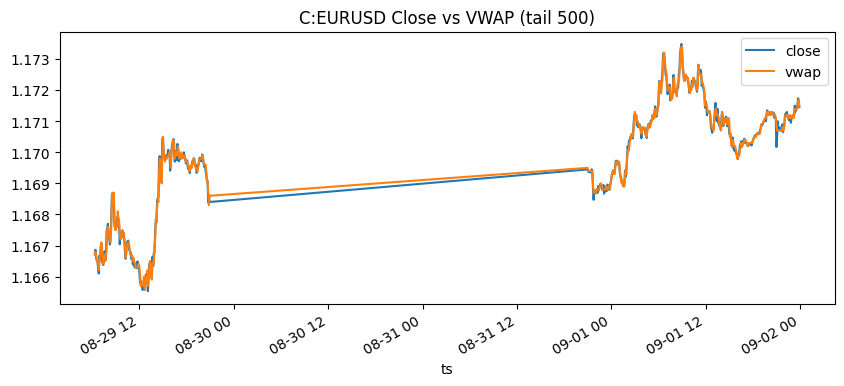

In [7]:
# 5) Feature Engineering
for sym, df in assets_data.items():
    if 'vwap' not in df or df['vwap'].isna().mean() > 0.1:
        df['vwap'] = compute_vwap(df)
    df['ma20'] = df['close'].rolling(20, min_periods=5).mean()
    df['sigma20'] = df['close'].pct_change().rolling(20, min_periods=5).std()
    df['atr14'] = atr(df, 14)
    df['tod'] = time_of_day_bucket(df.index, sym)

# Sample plot
one = ASSETS[0]
fig1, ax = plt.subplots(1,1, figsize=(10,4))
assets_data[one][['close','vwap']].tail(500).plot(ax=ax)
ax.set_title(f'{one} Close vs VWAP (tail 500)')
plt.show()


### 6) Higher-TF Hurst Context
Resample to 1H, compute rolling Hurst (R/S), smooth with EMA, label regimes.
- Bands: MR ≤ 0.45, NOISY 0.45–0.55, TREND ≥ 0.55
- Plot H with bands and show regime proportions


In [8]:
# Normalize indexes to UTC DatetimeIndex
for sym, df in assets_data.items():
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True, errors='coerce')
    elif df.index.tz is None:
        df.index = df.index.tz_localize('UTC')
    else:
        df.index = df.index.tz_convert('UTC')
    df.sort_index(inplace=True)

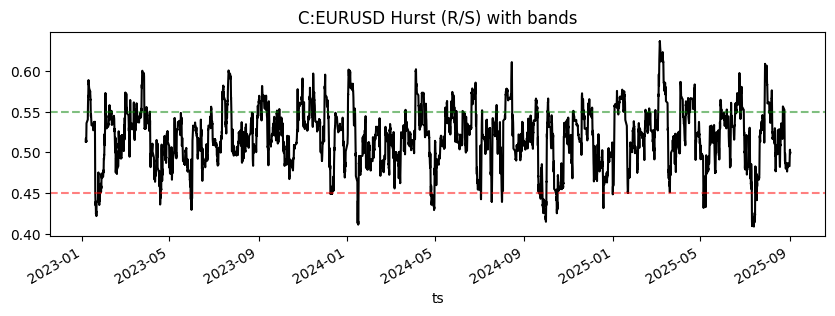

,asset,regime,p
0,C:EURUSD,NOISY,79.19
1,C:EURUSD,TREND,17.32
2,C:EURUSD,MR,3.50
3,C:GBPUSD,NOISY,72.64
4,C:GBPUSD,TREND,22.71
5,C:GBPUSD,MR,4.65
6,C:USDJPY,NOISY,67.61
7,C:USDJPY,TREND,30.15
8,C:USDJPY,MR,2.24
9,C:USDCHF,NOISY,71.59


In [9]:
# 6) Higher-TF Hurst Context
H_values, H_regimes = {}, {}
for sym, df in assets_data.items():
    r = df['close'].resample('h').last().pct_change(fill_method=None).dropna()
    H = rolling_hurst(r, win=H_WIN, ema_span=H_EMA)
    H_values[sym] = H
    H_regimes[sym] = label_h_regime(H, low=H_BANDS[0], high=H_BANDS[1])

# Plot H for one asset
fig_h, ax = plt.subplots(1,1, figsize=(10,3))
H_values[one].plot(ax=ax, color='k')
ax.axhline(H_BANDS[0], color='r', ls='--', alpha=0.5)
ax.axhline(H_BANDS[1], color='g', ls='--', alpha=0.5)
ax.set_title(f'{one} Hurst (R/S) with bands')
plt.show()

# Regime proportions
reg_props = []
for sym, reg in H_regimes.items():
    props = reg.value_counts(normalize=True)
    for k, v in props.items():
        reg_props.append({'asset': sym, 'regime': k, 'p': round(100*v,2)})
regime_table = pd.DataFrame(reg_props)
regime_table


In [10]:
for sym in ASSETS:
    H = H_values[sym].dropna()
    reg = H_regimes[sym].dropna()
    print(f'\n{sym}')
    print('H mean/median/min/max:', round(H.mean(),3), round(H.median(),3), round(H.min(),3), round(H.max(),3))
    print('H in [0,1]:', bool((H.between(0,1)).all()))
    props = (reg.value_counts(normalize=True)*100).round(2)
    print('Regime %:', props.to_dict(), 'Total:', round(props.sum(),2))


C:EURUSD
H mean/median/min/max: 0.518 0.519 0.409 0.636
H in [0,1]: True
Regime %: {'NOISY': 79.19, 'TREND': 17.32, 'MR': 3.5} Total: 100.01

C:GBPUSD
H mean/median/min/max: 0.52 0.521 0.413 0.624
H in [0,1]: True
Regime %: {'NOISY': 72.64, 'TREND': 22.71, 'MR': 4.65} Total: 100.0

C:USDJPY
H mean/median/min/max: 0.526 0.525 0.403 0.624
H in [0,1]: True
Regime %: {'NOISY': 67.61, 'TREND': 30.15, 'MR': 2.24} Total: 100.0

C:USDCHF
H mean/median/min/max: 0.517 0.517 0.373 0.639
H in [0,1]: True
Regime %: {'NOISY': 71.59, 'TREND': 23.03, 'MR': 5.38} Total: 100.0

C:AUDUSD
H mean/median/min/max: 0.506 0.507 0.362 0.64
H in [0,1]: True
Regime %: {'NOISY': 72.86, 'TREND': 14.97, 'MR': 12.17} Total: 100.0

C:USDCAD
H mean/median/min/max: 0.5 0.498 0.388 0.614
H in [0,1]: True
Regime %: {'NOISY': 80.27, 'TREND': 10.12, 'MR': 9.61} Total: 100.0


### 7) Event Labeling (Anchored VWAP Reversion)
Trigger on |close − anchored VWAP|/anchored VWAP ≥ threshold; success when the signed deviation flips sign within N bars.
- Anchored VWAP resets per UTC day (computed in helpers)
- Outputs: trigger, success, side, time-to-reversion (ttr)


In [11]:
# 7) Event Labeling (VWAP Reversion)
th = DEV_THRESH[1]
hz = HORIZONS[1]
labels = {}
for sym, df in assets_data.items():
    trig, succ, side, ttr = label_vwap_reversion(df, threshold_pct=th, horizon=hz)
    labels[sym] = {'trigger': trig, 'success': succ, 'side': side, 'ttr': ttr}
    print(sym, 'trig:', int(trig.sum()), 'succ:', int((succ & trig).sum()))

sum_tbl = []
for sym in ASSETS:
    t = int(labels[sym]['trigger'].sum())
    s = int((labels[sym]['success'] & labels[sym]['trigger']).sum())
    sum_tbl.append({'asset': sym, 'triggers': t, 'success': s, 'p': round(s/max(t,1),3)})
pd.DataFrame(sum_tbl)


C:EURUSD trig: 81104 succ: 7677
C:GBPUSD trig: 85280 succ: 8318
C:USDJPY trig: 102100 succ: 10829
C:USDCHF trig: 84879 succ: 9440
C:AUDUSD trig: 110345 succ: 13218
C:USDCAD trig: 65754 succ: 6370


,asset,triggers,success,p
0,C:EURUSD,81104,7677,0.095
1,C:GBPUSD,85280,8318,0.098
2,C:USDJPY,102100,10829,0.106
3,C:USDCHF,84879,9440,0.111
4,C:AUDUSD,110345,13218,0.120
5,C:USDCAD,65754,6370,0.097


### 8) EDA — Base and Conditionals
Compute base P(revert) by regime, and conditionals by deviation bin × regime × side.


In [12]:
# 8) EDA — Frequency, Base Edge, Conditionals
base_rows = []
cond_tables = []
for sym, df in assets_data.items():
    reg = H_regimes[sym].reindex(df.index, method='ffill')
    trig = labels[sym]['trigger']
    succ = labels[sym]['success']
    side = labels[sym]['side']

    # Base per regime
    for r in ['MR','NOISY','TREND']:
        m = (reg == r)
        n_trig = int((trig & m).sum())
        n_succ = int((succ & trig & m).sum())
        p = (n_succ / n_trig) if n_trig > 0 else np.nan
        base_rows.append({'asset': sym, 'regime': r, 'triggers': n_trig, 'success': n_succ, 'p': p})

    # Conditionals: deviation x regime x side
    dev_abs = deviation_pct_from_vwap(df['close'], df['vwap']).abs()
    dev_bin = pd.cut(dev_abs, bins=[-1, DEV_THRESH[0], DEV_THRESH[1], DEV_THRESH[2], 1e9], labels=['<t0','t0-t1','t1-t2','>t2'])
    tbl = conditional_probability_table((succ & trig), {'dev': dev_bin, 'reg': reg, 'side': side})
    tbl['asset'] = sym
    cond_tables.append(tbl)

base_table = pd.DataFrame(base_rows)
cond_table = pd.concat(cond_tables, ignore_index=True)

base_table.head(), cond_table.head()


(      asset regime  triggers  success         p
 0  C:EURUSD     MR      2458      305  0.124085
 1  C:EURUSD  NOISY     62999     5736  0.091049
 2  C:EURUSD  TREND     15088     1583  0.104918
 3  C:GBPUSD     MR      3741      376  0.100508
 4  C:GBPUSD  NOISY     61207     5860  0.095741,
    dev    reg  side         p      n     asset
 0  <t0     MR  down  0.043959   3344  C:EURUSD
 1  <t0     MR    up  0.043616   3462  C:EURUSD
 2  <t0  NOISY  down  0.034949  78200  C:EURUSD
 3  <t0  NOISY    up  0.036649  76619  C:EURUSD
 4  <t0  TREND  down  0.043322  16089  C:EURUSD)

### 9) Monotonicity Check & Stability Check
Ensure P(revert) increases with larger deviation bins within each regime/side.
Compare first vs second half; report max/median absolute delta in P(revert).

In [13]:
from helpers import monotonicity_check, stability_summary

# cond_table already built earlier
mono_pass, mono_df = monotonicity_check(cond_table)

stab_df = stability_summary(assets_data, H_regimes, labels, DEV_THRESH)
print('Monotonicity pass rate:', round(mono_pass, 3))
stab_df

/Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/helpers.py:642: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, grp in cond_table.groupby(list(group_cols)):


Monotonicity pass rate: 0.889


,asset,max_abs_delta_p,median_abs_delta_p
0,C:EURUSD,0.085714,0.024800
1,C:GBPUSD,0.100000,0.017496
2,C:USDJPY,0.166667,0.022987
3,C:USDCHF,0.210526,0.025584
4,C:AUDUSD,0.625000,0.076923
5,C:USDCAD,0.576923,0.045455


In [14]:
# Asset-level decision and filtering
KEEP_ASSETS, REJECTS = [], []
for sym in sorted(base_table['asset'].unique()):
    bt = base_table[base_table['asset'] == sym]
    ct = cond_table[cond_table['asset'] == sym]
    sd = stab_df[stab_df['asset'] == sym]
    dec, why = decision_gate(
        bt, ct, sd,
        min_triggers=2000,      # per-asset min triggers
        min_mono_pass=0.6,
        max_median_delta=0.03   # slightly looser for alts
    )
    (KEEP_ASSETS if dec == 'KEEP' else REJECTS).append((sym, why))

print('KEEP_ASSETS:', [a for a,_ in KEEP_ASSETS])
print('REJECTS:', REJECTS)

# Optional: restrict downstream to kept assets only
if KEEP_ASSETS:
    kept = {a for a,_ in KEEP_ASSETS}
    assets_data = {k:v for k,v in assets_data.items() if k in kept}
    # Rebuild base_table/cond_table/etc if you want fully filtered EDA

KEEP_ASSETS: ['C:EURUSD', 'C:GBPUSD', 'C:USDCHF', 'C:USDJPY']
REJECTS: [('C:AUDUSD', ['stability weak: median |Δp|=0.077 > 0.030']), ('C:USDCAD', ['stability weak: median |Δp|=0.045 > 0.030'])]


/Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/helpers.py:642: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, grp in cond_table.groupby(list(group_cols)):
/Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/helpers.py:642: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, grp in cond_table.groupby(list(group_cols)):
/Users/justinborneo/Desktop/Desktop - Justin’s MacBook Pro/Trading Research/helpers.py:642: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False 

### 11) Decision Gate (EDA-only)
Use helpers-based decision_gate to print KEEP or STOP and reasons based on triggers, monotonicity, and stability.


In [15]:
# 11) Decision Gate (per-asset aware)
from helpers import decision_gate

if 'KEEP_ASSETS' in globals() and KEEP_ASSETS:
    DECISION = 'KEEP'
    reasons = []
    print('Decision:', DECISION)
    print('Assets kept:', KEEP_ASSETS)
else:
    DECISION, reasons = decision_gate(base_table, cond_table, stab_df,
                                      min_triggers=200, min_mono_pass=0.6, max_median_delta=0.02)
    print('Decision:', DECISION)
    if reasons:
        print('Reasons:')
        for r in reasons:
            print('-', r)

# Make kept assets available to later cells (packaging)
KEPT_ASSETS = KEEP_ASSETS if ('KEEP_ASSETS' in globals() and KEEP_ASSETS) else list(sorted(base_table['asset'].unique()))

Decision: KEEP
Assets kept: [('C:EURUSD', []), ('C:GBPUSD', []), ('C:USDCHF', []), ('C:USDJPY', [])]


### 12) Visuals — Kept Assets
Additional multi-asset visuals focusing on kept assets:
- Per-asset heatmaps (Deviation × Regime)
- Per-asset reliability curves (Deviation bin vs P(revert))
- Bar chart: base P(revert) by regime & asset
- Time-of-day curves (per asset)


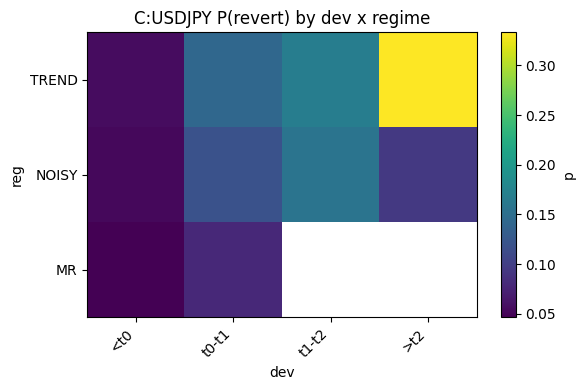

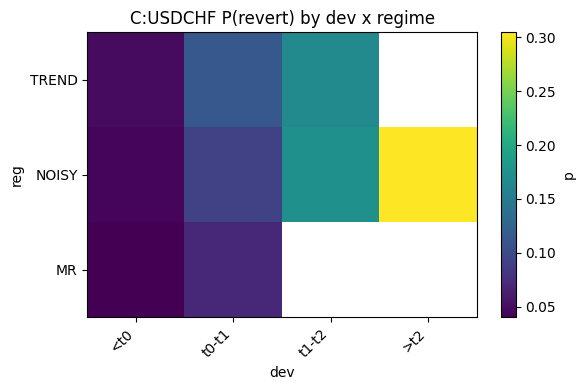

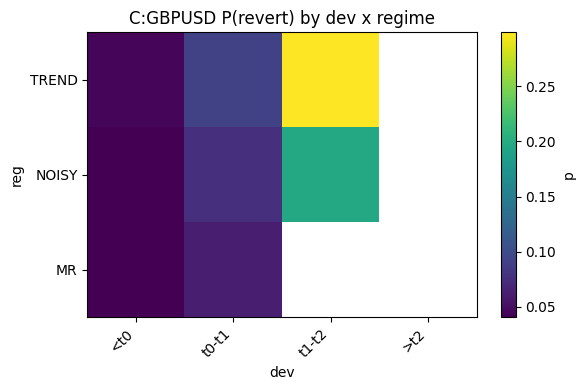

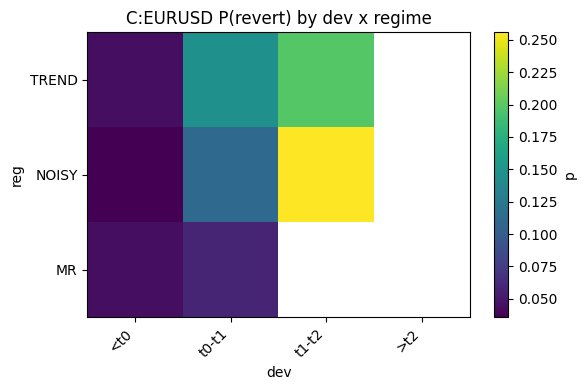

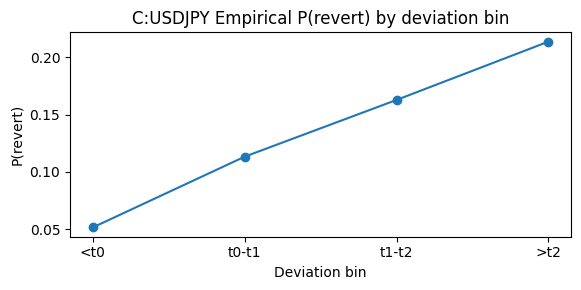

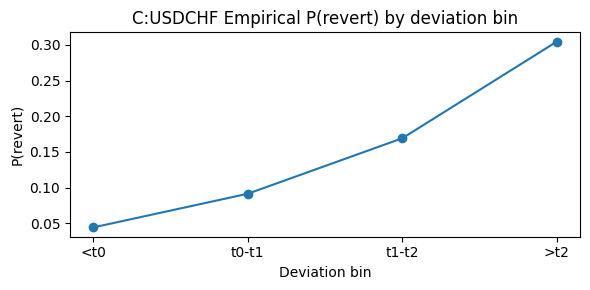

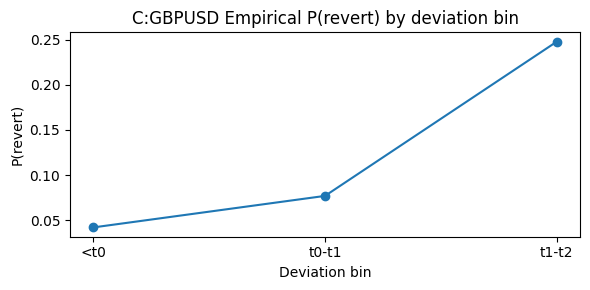

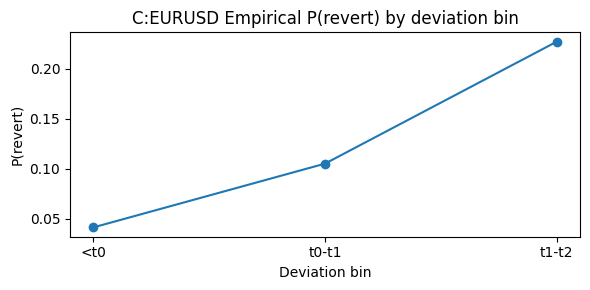

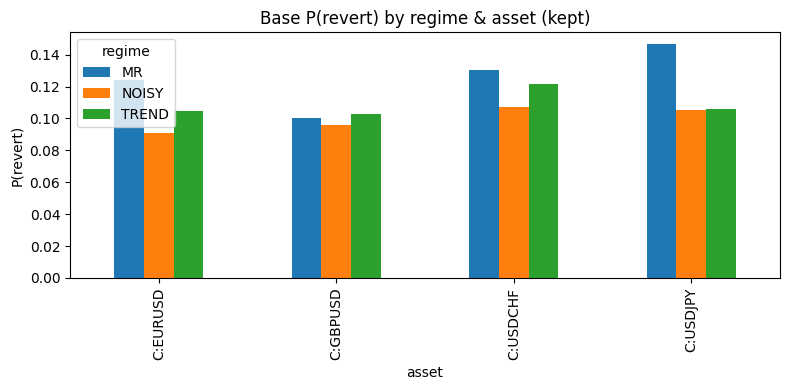

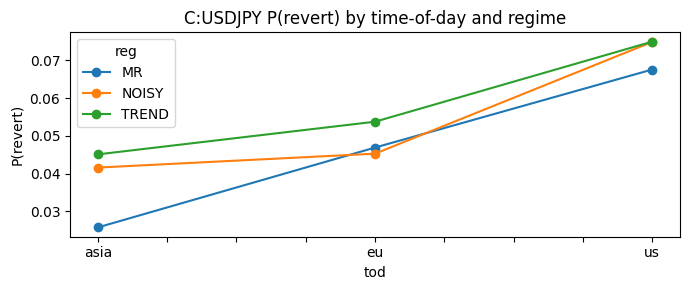

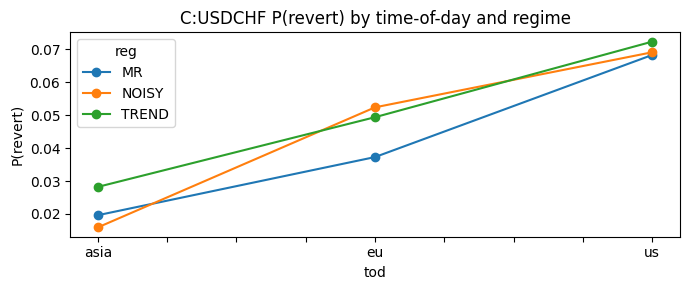

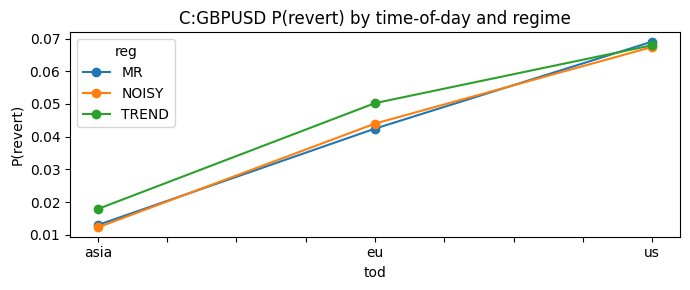

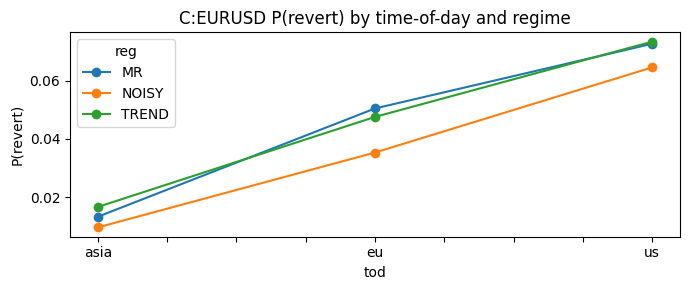

In [16]:
# Visuals for kept assets
kept_list = KEPT_ASSETS if 'KEPT_ASSETS' in globals() else list(base_table['asset'].unique())
kept = {a if isinstance(a, str) else a[0] for a in kept_list}
# Per-asset heatmaps
fig_heat_assets = {}
for sym in kept:
    one_tbl = cond_table[cond_table['asset']==sym]
    if one_tbl.empty:
        continue
    ht = one_tbl.groupby(['dev','reg'], observed=True)['p'].mean().reset_index()
    fig = plot_heatmap(ht, x='dev', y='reg', value='p', title=f'{sym} P(revert) by dev x regime')
    fig_heat_assets[sym] = fig

# Per-asset reliability curves
fig_rel_assets = {}
for sym in kept:
    one_tbl = cond_table[cond_table['asset']==sym]
    if one_tbl.empty:
        continue
    ht = one_tbl.groupby(['dev'], observed=True)['p'].mean().reset_index()
    fig, ax = plt.subplots(1,1, figsize=(6,3))
    ax.plot(ht['dev'].astype(str), ht['p'], marker='o')
    ax.set_title(f'{sym} Empirical P(revert) by deviation bin')
    ax.set_xlabel('Deviation bin')
    ax.set_ylabel('P(revert)')
    plt.tight_layout()
    fig_rel_assets[sym] = fig

# Base P(revert) by regime & asset (bar chart)
fig_base, ax = plt.subplots(1,1, figsize=(8,4))
base_kept = base_table[base_table['asset'].isin(kept)]
base_pivot = base_kept.pivot(index='asset', columns='regime', values='p')
base_pivot.plot(kind='bar', ax=ax)
ax.set_title('Base P(revert) by regime & asset (kept)')
ax.set_ylabel('P(revert)')
plt.tight_layout()

# Time-of-day curves (per asset)
fig_tod_assets = {}
DEV_ORDER = ['<t0','t0-t1','t1-t2','>t2']
for sym in kept:
    df = assets_data.get(sym)
    if df is None or df.empty:
        continue
    reg = H_regimes[sym].reindex(df.index, method='ffill')
    trig = labels[sym]['trigger']
    succ = labels[sym]['success']
    dev_abs = (df['close']/df['vwap'] - 1).abs()*100
    dev_bin = pd.cut(dev_abs, bins=[-1, DEV_THRESH[0], DEV_THRESH[1], DEV_THRESH[2], 1e9], labels=DEV_ORDER)
    tod = df['tod']
    tbl = conditional_probability_table((succ & trig), {'tod': tod, 'reg': reg})
    if tbl.empty:
        continue
    fig, ax = plt.subplots(1,1, figsize=(7,3))
    pivot = tbl.pivot(index='tod', columns='reg', values='p')
    pivot.plot(ax=ax, marker='o')
    ax.set_title(f'{sym} P(revert) by time-of-day and regime')
    ax.set_ylabel('P(revert)')
    plt.tight_layout()
    fig_tod_assets[sym] = fig


### Packing and Final Summary 

### 13) Packaging — include all key figures and tables
Saves config, summary tables, and all visuals (including per-asset) into `studies/<timestamp>_VWAP_Reversion/plots/`.


In [17]:
# 13) Packaging — include all key figures and tables
# Collect figures
figures = {
    'hurst_regimes': fig_h,
    'heatmap_global': fig_heat,
    'reliability_global': fig_rel,
}

# Add per-asset visuals if present
if 'fig_heat_assets' in globals():
    for sym, fig in fig_heat_assets.items():
        figures[f'heatmap_{sym}'] = fig
if 'fig_rel_assets' in globals():
    for sym, fig in fig_rel_assets.items():
        figures[f'reliability_{sym}'] = fig
if 'fig_tod_assets' in globals():
    for sym, fig in fig_tod_assets.items():
        figures[f'tod_{sym}'] = fig
if 'fig_base' in globals():
    figures['base_regime_bar'] = fig_base
if 'fig_ttrs' in globals():
    for sym, fig in fig_ttrs.items():
        figures[f'ttr_{sym}'] = fig

# Tables to save
tables = {
    'eda_summary': base_table.copy(),
}
if 'cond_table' in globals():
    tables['eda_conditionals'] = cond_table.copy()
if 'regime_table' in globals():
    tables['regime_props'] = regime_table.copy()
if 'coverage' in globals():
    tables['coverage'] = coverage.copy()

# Config
cfg = dict(
    ASSETS=ASSETS,
    KEPT_ASSETS=(KEPT_ASSETS if 'KEPT_ASSETS' in globals() else ASSETS),
    START=START,
    END=END,
    INTRADAY_MULTIPLIER=INTRADAY_MULTIPLIER,
    H_WIN=H_WIN,
    H_EMA=H_EMA,
    H_BANDS=H_BANDS,
    DEV_THRESH=DEV_THRESH,
    HORIZONS=HORIZONS,
    STUDY_NAME=STUDY_NAME,
    DECISION=DECISION,
)

out_dir = package_study(STUDY_NAME, cfg, figures, tables)
print('Packaged to:', out_dir)


NameError: name 'fig_heat' is not defined

In [ ]:
# 14) Final Summary
from IPython.display import Markdown, display

# Metrics for summary
kept = KEPT_ASSETS if 'KEPT_ASSETS' in globals() else ASSETS
if isinstance(kept, list) and kept and isinstance(kept[0], tuple):
    kept = [a for a,_ in kept]

if 'base_table' in globals():
    bt_kept = base_table[base_table['asset'].isin(kept)]
    total_trigs = int(bt_kept['triggers'].sum()) if len(bt_kept) else 0
    avg_p = float(bt_kept['p'].mean()) if len(bt_kept) else float('nan')
else:
    total_trigs, avg_p = 0, float('nan')

# Monotonicity/stability
if 'mono_pass' in globals():
    mono_rate = mono_pass
elif 'cond_table' in globals():
    from helpers import monotonicity_check
    mono_rate, _ = monotonicity_check(cond_table)
else:
    mono_rate = float('nan')

if 'stab_df' in globals() and len(stab_df):
    stab_kept = stab_df[stab_df['asset'].isin(kept)]
    median_delta = float(stab_kept['median_abs_delta_p'].median()) if len(stab_kept) else float('nan')
else:
    median_delta = float('nan')

summary = f"""
- Study: VWAP Reversion EDA
- Span: {START} → {END}
- Decision: {DECISION}
- Assets (kept): {kept}
- Triggers (kept): {total_trigs}
- Mean P(revert) (kept): {avg_p:.3f}
- Monotonicity pass rate: {mono_rate:.2f}
- Stability median |Δp|: {median_delta:.3f}
- Packaged: {out_dir}
"""
display(Markdown(summary))
